<a href="https://colab.research.google.com/github/mjvakili/Land_use_classification/blob/master/land_cover_vanila_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Land Cover Classification

In this work we make use of the images collected by the European *Sentinel* Satellite to perform land cover classification. 

For more information about the data curation please refer to the following articles:

```[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.```

```[2] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018. ```

The data can be accessed through the following link: [EuroSAT : Land Use and Land Cover Classification with Sentinel-2](https://github.com/phelber/EuroSAT). The author note that by training a COnvolutional Neural Network they can achieve a 98\% accuracy in land use and land cover classification.


In [1]:
import os
import zipfile
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.image as mpimg
from glob import glob 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
#sklearn helpers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

Using TensorFlow backend.


In this project we use the eurosat data which is a benchmark dataset for land cover and land use classification. 




In [2]:
#Download the file and save it in a temporary placeholder '/tmp'
!wget --no-check-certificate \
  http://madm.dfki.de/files/sentinel/EuroSAT.zip \
  -O /tmp/eurosat.zip

--2020-02-11 10:27:20--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘/tmp/eurosat.zip’

/tmp/eurosat.zip    100%[===================>]  89.91M  20.1MB/s    in 6.1s    

2020-02-11 10:27:27 (14.7 MB/s) - ‘/tmp/eurosat.zip’ saved [94280567/94280567]



In [0]:
#Unzip the file in '/tmp'
local_zip = '/tmp/eurosat.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [0]:
#Split the data into train, valid, test folders
base_dir = "/tmp/2750"

In [0]:
Classes = ["AnnualCrop","HerbaceousVegetation","Industrial","PermanentCrop","River","Forest","Highway","Pasture","Residential","SeaLake"]

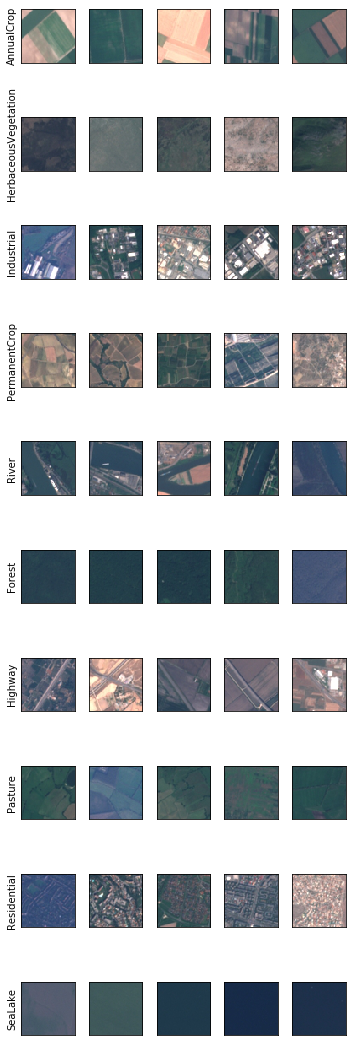

In [6]:
NC = len(Classes)
Ncols = 5
Nsamples = []
fig, ax = plt.subplots(nrows = NC, ncols = Ncols, figsize = (5,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for (i,Class) in enumerate(Classes):
  
  Class_dir = os.path.join(base_dir, Class)
  Class_files = os.listdir(Class_dir)
  nsamples = len(Class_files)
  Nsamples.append(nsamples)
  Class_samples = Class_files[:Ncols]
  
  for j in range(Ncols):
    
    img_path = os.path.join(Class_dir, Class_samples[j])
    img = mpimg.imread(img_path)
    ax[i, j].imshow(img)
    ax[i,0].set_ylabel(Class, fontsize = 10)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

plt.tight_layout()    

Text(0, 0.5, 'Number of instances in each class')

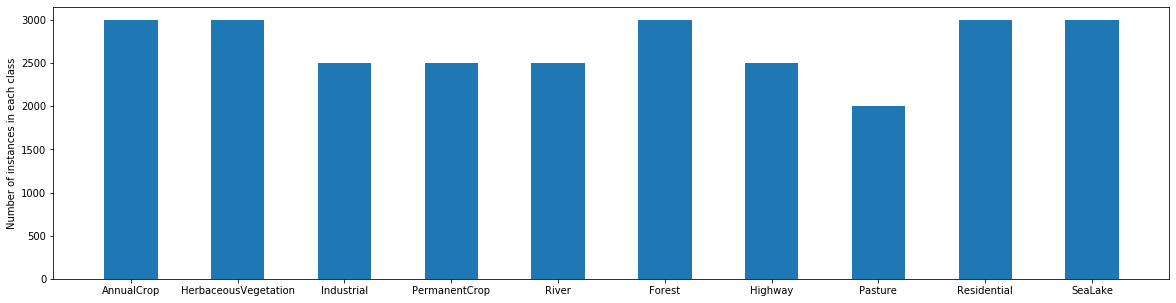

In [7]:
plt.figure(figsize = (20,5))
plt.bar(Classes, Nsamples, width = 0.5, color = "C0", label='Alone')
plt.ylabel("Number of instances in each class", fontsize  = 10)

We notice that this is a pretty balanced dataset

In [0]:
LR = 0.001
BATCH_SIZE = 64
NEPOCHS = 15
IMG_WIDTH, IMG_HEIGHT = 75, 75
VALIDATION_RATIO = 0.2

In [38]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip=True,
    
    validation_split=VALIDATION_RATIO) # set validation split

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') 

validation_generator = datagen.flow_from_directory(
    base_dir, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') 

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


##Convolutional Neural Net from scracth:

As a start, we make a simple CNN from scratch. 

In [0]:
def simple_model():
    model = models.Sequential([
      # The input shape is size of the image from the data generator IMG_WIDTHxIMG_HEIGHT with 3 channel color
      layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
      layers.MaxPooling2D(2, 2),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(512, activation='relu'),
      layers.Dense(10, activation='softmax')])
    
    return model

In [0]:

model = simple_model()

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 5, 128)        

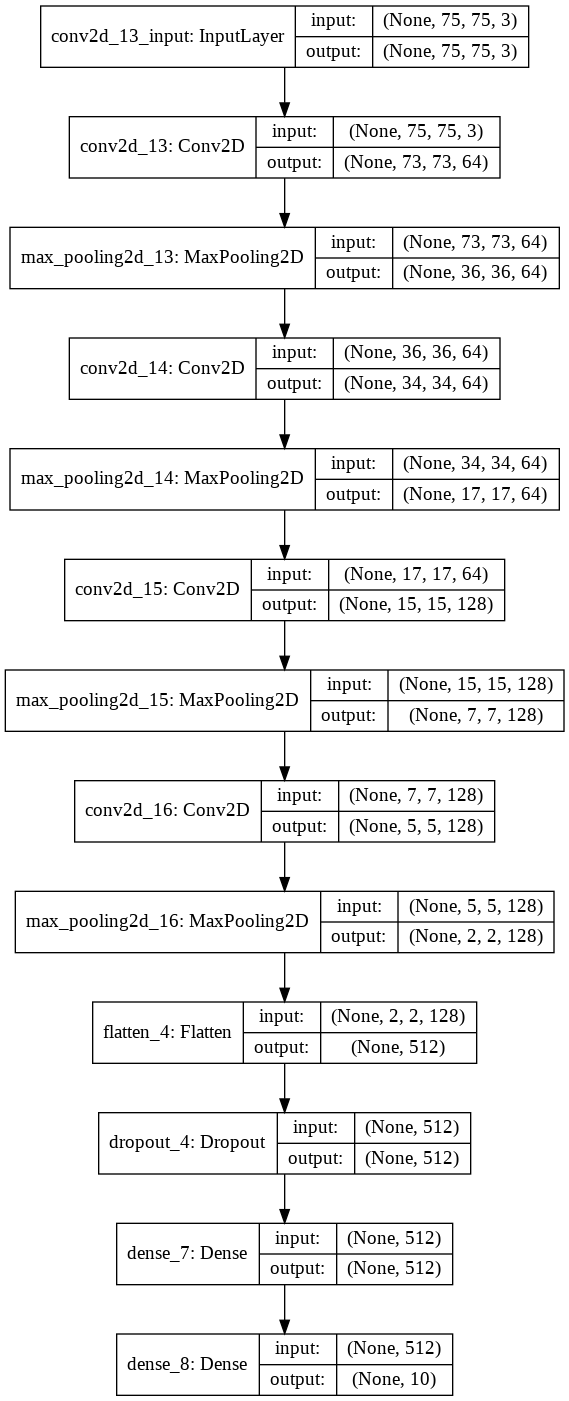

In [42]:
plot_model(model, show_shapes=True)

In [0]:
#Stop the optimization once the validation accuracy converges
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

#Schedul the learning rate
def scheduler(epoch):
  '''
  learning rate scheduler; keeps the learning rate 10^(-3) until 10 and then exponential decrease
  '''
  if epoch < 10:
    return LR
  else:
    return LR * np.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = LR), metrics=['accuracy'])

In [45]:
history = model.fit_generator(train_generator, 
                              epochs=40, 
                              validation_data = validation_generator,
                              callbacks=[early_stopping, learning_rate_scheduler], 
                              verbose = 1)

Epoch 1/40
338/338 [==============================] - 51s 151ms/step - loss: 1.5102 - acc: 0.4004 - val_loss: 1.1658 - val_acc: 0.5233
Epoch 2/40
338/338 [==============================] - 49s 145ms/step - loss: 1.0551 - acc: 0.6105 - val_loss: 0.8365 - val_acc: 0.6978
Epoch 3/40
338/338 [==============================] - 49s 145ms/step - loss: 0.8571 - acc: 0.6908 - val_loss: 0.6653 - val_acc: 0.7648
Epoch 4/40
338/338 [==============================] - 50s 146ms/step - loss: 0.7829 - acc: 0.7186 - val_loss: 0.6936 - val_acc: 0.7454
Epoch 5/40
338/338 [==============================] - 49s 144ms/step - loss: 0.7105 - acc: 0.7447 - val_loss: 0.6683 - val_acc: 0.7594
Epoch 6/40
338/338 [==============================] - 49s 146ms/step - loss: 0.6434 - acc: 0.7713 - val_loss: 0.7789 - val_acc: 0.7167
Epoch 7/40
338/338 [==============================] - 49s 145ms/step - loss: 0.6200 - acc: 0.7801 - val_loss: 0.5869 - val_acc: 0.7802
Epoch 8/40
338/338 [==============================] - 4

In [0]:
def plot_history(history):
  
  plt.figure(figsize = (10,6))
  plt.subplot(1,2,1)
  plt.plot(history.history["loss"], label = "loss")
  plt.plot(history.history["val_loss"], label = "validation loss")
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history["acc"], label = "accuracy")
  plt.plot(history.history["val_acc"], label = "validation accuracy")
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  return None

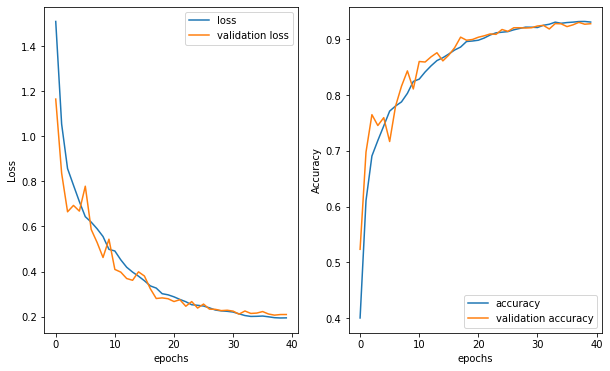

In [47]:
plot_history(history)

In [0]:
model.save("land_use.h5")

In [0]:
def vizualize_activations(img):
    '''
    It shows the output of different convolution and pooling 
    layers in the CNN

    input: image index in the test set 
    '''
    print("Vizualising the output of Convolution layers and Pooling layer for test example")
    layer_outputs = [layer.output for layer in model.layers][0]
    activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
    feature_maps = activation_model.predict(img)
    nlayers = len(feature_maps)
    for layer_index in range(0,1):
      layer_feature_maps = feature_maps[layer_index][0]
      layer_depth = layer_feature_maps.shape[-1]
      fig, ax = plt.subplots(nrows = 1, ncols = layer_depth)
      if np.mod(layer_index ,2) == 0:
        ax[0].set_ylabel("CONV2D")
      else:
        ax[0].set_ylabel("Average Pooling")  
      for i in range(layer_depth):
        ax[i].imshow(layer_feature_maps[:,:,i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    return None

In [0]:
#layer_outputs = [layer.output for layer in model.layers][0]
#activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [48]:
testing_generator = datagen.flow_from_directory(
                        base_dir, 
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        class_mode='categorical',
                        shuffle = False,
                        subset='validation')

Found 5400 images belonging to 10 classes.


In [0]:
#activation_map = activation_model.predict_generator(validation_generator)

In [0]:
test_labels = testing_generator.labels

In [0]:
test_preds = model.predict_generator(testing_generator)

In [0]:
#point-estimates!
test_best = test_preds.argmax(axis = -1)

In [54]:
report = classification_report(test_labels,
                               test_best,
                               labels = np.arange(10),
                               target_names = Classes)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.91      0.91       600
HerbaceousVegetation       0.97      0.97      0.97       600
          Industrial       0.91      0.89      0.90       600
       PermanentCrop       0.91      0.92      0.91       500
               River       0.94      0.94      0.94       500
              Forest       0.89      0.92      0.90       400
             Highway       0.89      0.85      0.87       500
             Pasture       0.96      0.95      0.96       600
         Residential       0.88      0.92      0.90       500
             SeaLake       0.98      0.99      0.98       600

            accuracy                           0.93      5400
           macro avg       0.92      0.92      0.92      5400
        weighted avg       0.93      0.93      0.93      5400



We note that we this simple CNN we can achieve almost 92\% accuracy, with the best performance coming from deteing Sea Lakes and Herbaceous Vegetation. Note that the authors of the paper mentioned in the begining claim that they achieve 98\% accuracy in land cover prediction. Given that we have only built a simple Convolutional Neural Network from Scracth with very little model tuning we are doing a relatively good job!

One possible way of improving on this is to take advantage of some of the deep pretrained CNNs such as Resenet, Densenet, or Inception.